# Identify Fraud from Enron Email
Project for Intro to Machine Learning  
## Goal:

### Project Overview
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

Provided is a combined the Enron email and financial dataset in the form of a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

### Project goal
The goal of the project is to see if I an make building a person of interest identifier that has reasonable accuracy and other metric scores to identify persons of interest from based on financial and email data made public as a result of the Enron scandal.

### Project Plan
The steps to achieve this will be:

* Dataset exploration / Question
* Features
* Algorithms
* Evaluation


## Used libraries and functions

In [1]:
# general libraries
import os
import pickle

# general data handling
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 200
# Machine learning

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.model_selection import StratifiedShuffleSplit
from tester import dump_classifier_and_data
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler

In [77]:
def remove_keys(dictionary, remove_list):
    """
    remove entry in dicrionary by key
    """
    for key in remove_list:
        try:
            del dictionary[key]
        except:
            print("error : " + str(key) + " not in dictionary" )
    return dictionary


def replace_nan_ndict(ndict):
    """
    replace NaN with 0 in the dictionary
    """
    for k,v in ndict.items():
        for key, value in v.items():
            if isinstance(value, (int, long, float, complex)) and not isinstance(value, bool):
                if isnan(value) == True:
                    ndict[k][key] = 0
            elif value == 'NaN':
                ndict[k][key] = 0
    return ndict


## Questions:
1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

## Data exploration
For the first part I am checking what is in the data, how consistent it is, etc.
from the rubric:

Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. Important characteristics include:

* total number of data points
* allocation across classes (POI/non-POI)
* number of features used
* are there features with many missing values? etc.

I'll first create a dataframe with the data, in order to explore a bit easier. In the Udacity lesson on outliers, we already identified the TOTAL row from the [financial overview](../final_project/enron61702insiderpay.pdf) Looking at the data, 'THE TRAVEL AGENCY IN THE PARK' also is an obvious candidate for removal, since this is not a person and we are looking for a person of interest.  
Additionally I'll clean up the NaN with np.nan, so I can have a better look with wuild in functions.

In [4]:
#read in dictionary from pkl
enron_data = pd.read_pickle("final_project_dataset.pkl")
# looking at the data, there are some obvious non-persons in the dictionary:
non_persons = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']
enron_data = remove_keys(enron_data, non_persons)
#create df from dictionary for ease of use
enron_df = pd.DataFrame.from_dict(enron_data)
enron_df = enron_df.transpose() #transpose
enron_df = enron_df.replace('NaN', np.nan)

### Summary of dataset
Pandas has some nice functions to get some general information:

In [5]:
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
bonus                        81 non-null float64
deferral_payments            38 non-null float64
deferred_income              48 non-null float64
director_fees                16 non-null float64
email_address                111 non-null object
exercised_stock_options      101 non-null float64
expenses                     94 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                3 non-null float64
long_term_incentive          65 non-null float64
other                        91 non-null float64
poi                          144 non-null bool
restricted_stock             109 non-null float64
restricted_stock_deferred    17 non-null float64
salary                       94 non-null float64
shared_receipt_with_poi      86 non-null float64



In the dataset there is a mix of different data: payment, stock and email information

payment features:  

| Feature | meaning |
|: -------|:--------|
| salary | Reflects items such as base salary, executive cash allowances, and benefits payments |
| bonus | Reflects annual cash incentives paid based upon company performance. Also may include other retention payments. |
| long_term_incentive |Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years. |
| deferred_income | Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.  |
| deferral_payments  |Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions. |
| loan_advances  | Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company. |
| other  |Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft. |
| expenses  | Reflects reimbursements of business expenses. May include fees paid for consulting services |
| director_fees | Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors. | 
| total_payments  | cumulative of all payments |
  
Stock features  

| Feature | meaning |
|: -------|:--------|
| exercised_stock_options | Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities. |
| restricted_stock | Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting periods, regardless of whether deferred. |
| restricted_stock_deferred  | Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement. |
| total_stock_value | cumulative value of stock |
  
email features  
  
| Feature | meaning |
|: -------|:--------|
| from_poi_to_this_person  | emails send from POI to this person |
| shared_receipt_with_poi  | emails which were also send to a POI |
| from_this_person_to_poi  | emails sent from this person to POI |
| to_messages | total messages to this person |
| from_messages | total messages from this person |
  
and then of course if the person is a poi, in this case identified as either sentenced or someone who took a plea deal as noted in this article : http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm and provided in the poi_names.txt

| Feature | meaning |
|---------|---------|
| poi  | person of interest |

We can see that there is some disparacy in availability of the data, we need to check if that is because it is non existent (someone didn't get a bonus) or non-available (emails not available for instance)

I would like to rearrange the columns in he following order to make it a bit more organized and get rid of the email address, since that does not say anything that we cannot get from the name already:

| POI | Payment columns | Stock Columns | Emails |

In [6]:
col_order = ['poi', 
             'salary', 
             'bonus', 
             'long_term_incentive', 
             'deferred_income',
             'deferral_payments', 
             'loan_advances', 
             'other', 
             'expenses', 
             'director_fees',
             'total_payments', 
             'exercised_stock_options', 
             'restricted_stock',
             'restricted_stock_deferred', 
             'total_stock_value',
             'from_poi_to_this_person', 
             'shared_receipt_with_poi', 
             'from_this_person_to_poi', 
             'to_messages',
             'from_messages']

payment_columns = ['salary', 
                   'bonus', 
                   'long_term_incentive', 
                   'deferred_income',
                   'deferral_payments', 
                   'loan_advances', 
                   'other', 
                   'expenses', 
                   'director_fees',
                   'total_payments']

stock_columns = ['exercised_stock_options', 
                 'restricted_stock',
                 'restricted_stock_deferred', 
                 'total_stock_value']

email_columns = ['from_poi_to_this_person', 
                 'shared_receipt_with_poi', 
                 'from_this_person_to_poi', 
                 'to_messages',
                 'from_messages']
enron_df = enron_df[col_order]

In [7]:
enron_df.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,from_this_person_to_poi,to_messages,from_messages
count,9.400000e+01,8.100000e+01,6.500000e+01,4.800000e+01,3.800000e+01,3.000000e+00,9.100000e+01,94.000000,16.000000,1.230000e+02,1.010000e+02,1.090000e+02,1.700000e+01,1.250000e+02,86.000000,86.000000,86.000000,86.000000,86.000000
mean,2.840875e+05,1.201773e+06,7.464912e+05,-5.810498e+05,8.416025e+05,2.797500e+07,4.664105e+05,54192.010638,89822.875000,2.641806e+06,2.959559e+06,1.147424e+06,6.218928e+05,3.352073e+06,64.895349,1176.465116,41.232558,2073.860465,608.790698
std,1.771311e+05,1.441679e+06,8.629174e+05,9.420764e+05,1.289323e+06,4.638256e+07,1.397376e+06,46108.377454,41112.700735,9.524694e+06,5.499450e+06,2.249770e+06,3.845528e+06,6.532883e+06,86.979244,1178.317641,100.073111,2582.700981,1841.033949
min,4.770000e+02,7.000000e+04,6.922300e+04,-3.504386e+06,-1.025000e+05,4.000000e+05,2.000000e+00,148.000000,3285.000000,1.480000e+02,3.285000e+03,-2.604490e+06,-1.787380e+06,-4.409300e+04,0.000000,2.000000,0.000000,57.000000,12.000000
25%,2.118020e+05,4.250000e+05,2.750000e+05,-6.112092e+05,7.964450e+04,1.200000e+06,1.203000e+03,22479.000000,83674.500000,3.969340e+05,5.067650e+05,2.520550e+05,-3.298250e+05,4.941360e+05,10.000000,249.750000,1.000000,541.250000,22.750000
50%,2.587410e+05,7.500000e+05,4.221580e+05,-1.519270e+05,2.210635e+05,2.000000e+06,5.158700e+04,46547.500000,106164.500000,1.101393e+06,1.297049e+06,4.410960e+05,-1.402640e+05,1.095040e+06,35.000000,740.500000,8.000000,1211.000000,41.000000
75%,3.086065e+05,1.200000e+06,8.318090e+05,-3.792600e+04,8.672112e+05,4.176250e+07,3.319830e+05,78408.500000,112815.000000,2.087530e+06,2.542813e+06,9.850320e+05,-7.241900e+04,2.606763e+06,72.250000,1888.250000,24.750000,2634.750000,145.500000
max,1.111258e+06,8.000000e+06,5.145434e+06,-8.330000e+02,6.426990e+06,8.152500e+07,1.035973e+07,228763.000000,137864.000000,1.035598e+08,3.434838e+07,1.476169e+07,1.545629e+07,4.911008e+07,528.000000,5521.000000,609.000000,15149.000000,14368.000000


What we can notice from these is that there is a significant difference in magnitude between the features (like emails and salary), so I expect scaling to be applied later on.  

Looking at the insiderpay document, the NaN values in these columns are actually 0, so we can replace these:

In [8]:
#fix for both df and dict
enron_df[payment_columns + stock_columns] = enron_df[payment_columns + stock_columns].fillna(0)
enron_data = replace_nan_ndict(enron_data)

it also looks like there are some outliers, let's have a look:

### Outliers
The first inspection will be visual on some of the most available features, and the two conglomerate features (totals)

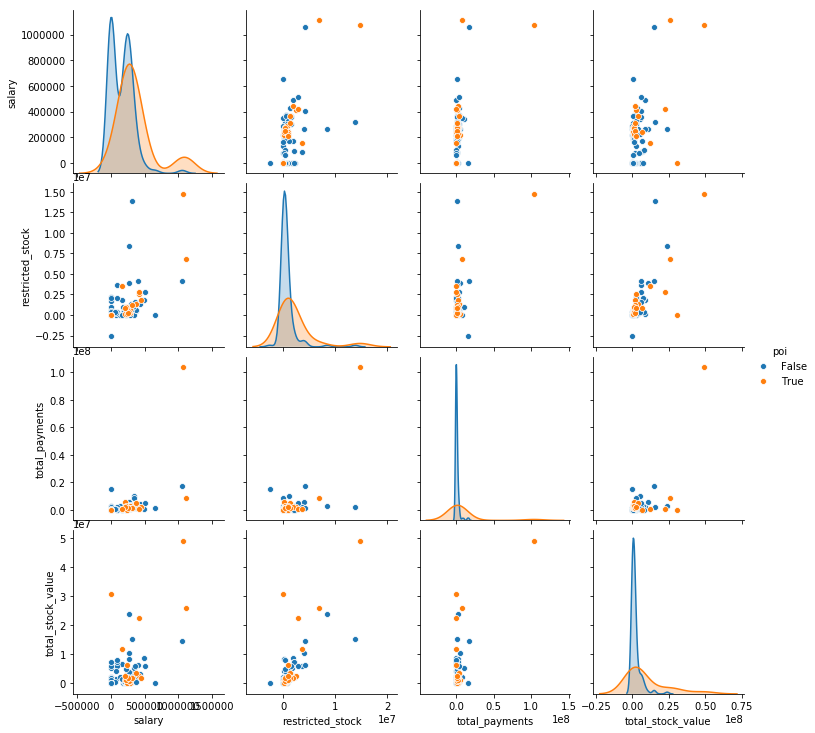

In [17]:
sns.pairplot(data=enron_df, vars=['salary', 'restricted_stock','total_payments', 'total_stock_value'], hue="poi")

We can see that there are some outliers to the top for all features and one point that looks odd on the negative side at restricted_stock.

Let's have a look at some outliers:

In [18]:
for clm in ['salary', 'total_payments', 'restricted_stock','total_stock_value']:
    print(enron_df.sort_values(clm,ascending=False)[[clm]].head(5))
    print("######################################################")

                       salary
SKILLING JEFFREY K  1111258.0
LAY KENNETH L       1072321.0
FREVERT MARK A      1060932.0
PICKERING MARK R     655037.0
WHALLEY LAWRENCE G   510364.0
######################################################
                    total_payments
LAY KENNETH L          103559793.0
FREVERT MARK A          17252530.0
BHATNAGAR SANJAY        15456290.0
LAVORATO JOHN J         10425757.0
SKILLING JEFFREY K       8682716.0
######################################################
                    restricted_stock
LAY KENNETH L             14761694.0
WHITE JR THOMAS E         13847074.0
PAI LOU L                  8453763.0
SKILLING JEFFREY K         6843672.0
FREVERT MARK A             4188667.0
######################################################
                    total_stock_value
LAY KENNETH L              49110078.0
HIRKO JOSEPH               30766064.0
SKILLING JEFFREY K         26093672.0
PAI LOU L                  23817930.0
RICE KENNETH D             225425

The disparity between payments at the top is quite high, but it does not seem to be out of the scope, especially since the top 1 is usually either Kenneth Lay, who is a POI or Jeffrey Skilling, who is also a POI.

Let's check the the minima:

In [19]:
for clm in ['salary', 'total_payments', 'restricted_stock','total_stock_value']:
    print(enron_df.sort_values(clm,ascending=True)[[clm]].head(5))
    print("######################################################")

                   salary
JAEDICKE ROBERT       0.0
MCCARTY DANNY J       0.0
LOWRY CHARLES P       0.0
LOCKHART EUGENE E     0.0
LEWIS RICHARD         0.0
######################################################
                        total_payments
LOWRY CHARLES P                    0.0
LEWIS RICHARD                      0.0
LOCKHART EUGENE E                  0.0
CHRISTODOULOU DIOMEDES             0.0
FOWLER PEGGY                       0.0
######################################################
                         restricted_stock
BHATNAGAR SANJAY               -2604490.0
YEAP SOON                             0.0
PEREIRA PAULO V. FERRAZ               0.0
MEYER JEROME J                        0.0
MENDELSOHN JOHN                       0.0
######################################################
                         total_stock_value
BELFER ROBERT                     -44093.0
CHAN RONNIE                            0.0
MENDELSOHN JOHN                        0.0
PEREIRA PAULO V. FERR

BELFER ROBERT and BHATNAGAR SANJAY have a negative value in columns where only positive values are expected. If we show these: 

In [20]:
enron_df.loc['BELFER ROBERT']

poi                           False
salary                            0
bonus                             0
long_term_incentive               0
deferred_income                   0
deferral_payments           -102500
loan_advances                     0
other                             0
expenses                          0
director_fees                  3285
total_payments               102500
exercised_stock_options        3285
restricted_stock                  0
restricted_stock_deferred     44093
total_stock_value            -44093
from_poi_to_this_person         NaN
shared_receipt_with_poi         NaN
from_this_person_to_poi         NaN
to_messages                     NaN
from_messages                   NaN
Name: BELFER ROBERT, dtype: object

In [21]:
enron_df.loc['BHATNAGAR SANJAY']

poi                                False
salary                                 0
bonus                                  0
long_term_incentive                    0
deferred_income                        0
deferral_payments                      0
loan_advances                          0
other                             137864
expenses                               0
director_fees                     137864
total_payments               1.54563e+07
exercised_stock_options      2.60449e+06
restricted_stock            -2.60449e+06
restricted_stock_deferred    1.54563e+07
total_stock_value                      0
from_poi_to_this_person                0
shared_receipt_with_poi              463
from_this_person_to_poi                1
to_messages                          523
from_messages                         29
Name: BHATNAGAR SANJAY, dtype: object

When we compare these with the original pdf, the columns shifted, so I fix it in the dictionary

In [22]:
enron_data['BHATNAGAR SANJAY'] = {'salary': 0,
 'to_messages': 523,
 'total_stock_value': 15456290,
 'deferral_payments': 0,
 'total_payments': 137864,
 'loan_advances': 0,
 'bonus': 0,
 'email_address': 'sanjay.bhatnagar@enron.com',
 'restricted_stock_deferred': -2604490,
 'deferred_income': 0,
 'expenses': 137864,
 'from_poi_to_this_person': 0,
 'exercised_stock_options': 15456290,
 'from_messages': 29,
 'other': 0,
 'from_this_person_to_poi': 1,
 'poi': False,
 'long_term_incentive': 0,
 'shared_receipt_with_poi': 463,
 'restricted_stock': 2604490,
 'director_fees': 0}

enron_data['BELFER ROBERT'] = {'salary': 0,
 'to_messages': 0,
 'deferral_payments': 0,
 'total_payments': 3285,
 'loan_advances': 0,
 'bonus': 0,
 'email_address': 0,
 'restricted_stock_deferred': -44093,
 'deferred_income': -102500,
 'total_stock_value': 0,
 'expenses': 3285,
 'from_poi_to_this_person': 0,
 'exercised_stock_options': 0,
 'from_messages': 0,
 'other': 0,
 'from_this_person_to_poi': 0,
 'poi': False,
 'long_term_incentive': 0,
 'shared_receipt_with_poi': 0,
 'restricted_stock': 44093,
 'director_fees': 102500}


check if there is anybody without financial information: 

In [23]:
enron_df[(enron_df[payment_columns + stock_columns] == 0).all(axis=1)]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,from_this_person_to_poi,to_messages,from_messages
LOCKHART EUGENE E,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


It seems he does not have any email info either, so I don't think he contributes anything to the dataset, so we remove him:

In [24]:
enron_data = remove_keys(enron_data, ['LOCKHART EUGENE E'])

Once more we have a look at the outliers for the clean dataset:

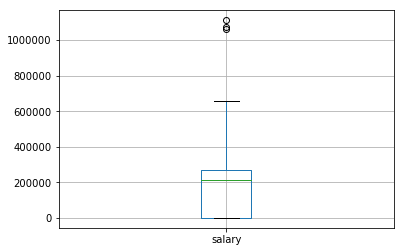

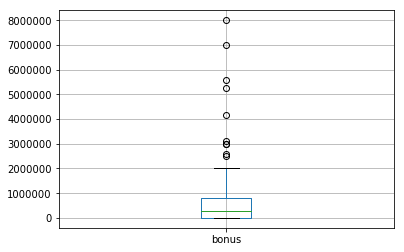

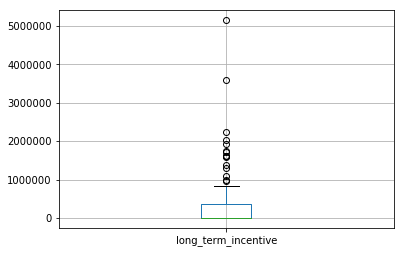

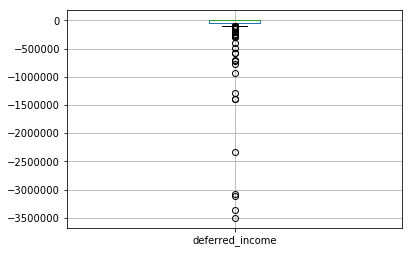

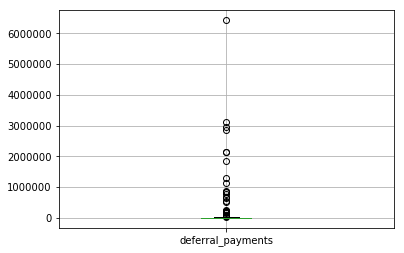

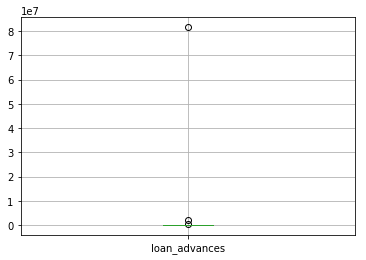

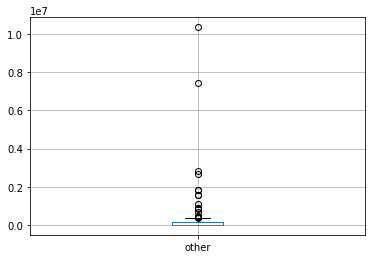

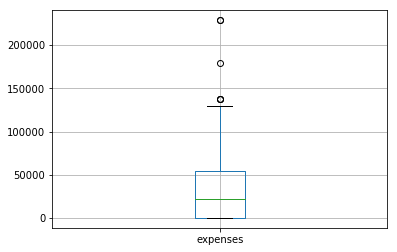

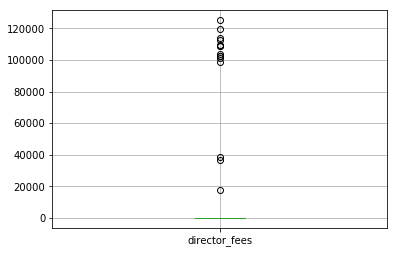

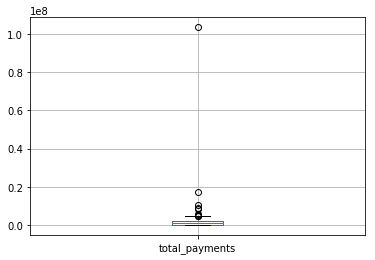

In [25]:
enron_df = pd.DataFrame.from_dict(enron_data)
enron_df = enron_df.transpose() #transpose
enron_df = enron_df[col_order].replace('NaN', np.nan).fillna(0)

for clm in payment_columns:
    plt.figure()
    enron_df.boxplot(column = [clm], figsize = (5,5))

In [26]:
enron_df.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,from_this_person_to_poi,to_messages,from_messages
count,1.430000e+02,1.430000e+02,1.430000e+02,1.430000e+02,1.430000e+02,1.430000e+02,1.430000e+02,143.000000,143.000000,1.430000e+02,1.430000e+02,1.430000e+02,1.430000e+02,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000
mean,1.867429e+05,6.807246e+05,3.393142e+05,-1.957545e+05,2.243594e+05,5.868881e+05,2.958426e+05,36609.776224,9779.839161,2.164507e+06,2.180168e+06,9.113447e+05,-5.298453e+04,3.038528e+06,39.027972,707.524476,24.797203,1247.216783,366.125874
std,1.971171e+05,1.236180e+06,6.890139e+05,6.077513e+05,7.562581e+05,6.818177e+06,1.135225e+06,46050.414344,30518.511971,8.808364e+06,4.937260e+06,2.005941e+06,2.741079e+05,6.288440e+06,74.466359,1079.457016,80.031821,2243.006069,1455.452279
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.504386e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,-3.979800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,8.929250e+04,0.000000e+00,4.569850e+04,0.000000e+00,2.882120e+05,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.106920e+05,3.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.910000e+02,22344.000000,0.000000,9.161970e+05,6.087500e+05,3.634280e+05,0.000000e+00,9.850320e+05,4.000000,114.000000,0.000000,383.000000,18.000000
75%,2.702590e+05,8.000000e+05,3.748255e+05,0.000000e+00,9.110000e+03,0.000000e+00,1.492040e+05,54522.000000,0.000000,1.901558e+06,1.698900e+06,8.611420e+05,0.000000e+00,2.413008e+06,41.500000,967.500000,14.000000,1639.000000,54.000000
max,1.111258e+06,8.000000e+06,5.145434e+06,0.000000e+00,6.426990e+06,8.152500e+07,1.035973e+07,228763.000000,125034.000000,1.035598e+08,3.434838e+07,1.476169e+07,0.000000e+00,4.911008e+07,528.000000,5521.000000,609.000000,15149.000000,14368.000000


In [32]:
for clm in ['salary', 'total_payments', 'restricted_stock','total_stock_value']:
    print(enron_df.sort_values(clm,ascending=False)[[clm]].head(5))
    print("######################################################")

                     salary
SKILLING JEFFREY K  1111258
LAY KENNETH L       1072321
FREVERT MARK A      1060932
PICKERING MARK R     655037
WHALLEY LAWRENCE G   510364
######################################################
                    total_payments
LAY KENNETH L            103559793
FREVERT MARK A            17252530
LAVORATO JOHN J           10425757
SKILLING JEFFREY K         8682716
MARTIN AMANDA K            8407016
######################################################
                    restricted_stock
LAY KENNETH L               14761694
WHITE JR THOMAS E           13847074
PAI LOU L                    8453763
SKILLING JEFFREY K           6843672
FREVERT MARK A               4188667
######################################################
                    total_stock_value
LAY KENNETH L                49110078
HIRKO JOSEPH                 30766064
SKILLING JEFFREY K           26093672
PAI LOU L                    23817930
RICE KENNETH D               22542539
#######

In [33]:
for clm in ['salary', 'total_payments', 'restricted_stock','total_stock_value']:
    print(enron_df.sort_values(clm,ascending=True)[[clm]].head(5))
    print("######################################################")

                   salary
JAEDICKE ROBERT         0
MCCARTY DANNY J         0
LOWRY CHARLES P         0
LEWIS RICHARD           0
LEMAISTRE CHARLES       0
######################################################
                 total_payments
MCCARTY DANNY J               0
HUGHES JAMES A                0
LEWIS RICHARD                 0
LOWRY CHARLES P               0
CHAN RONNIE                   0
######################################################
               restricted_stock
YEAP SOON                     0
FOY JOE                       0
FUGH JOHN L                   0
GIBBS DANA R                  0
GRAMM WENDY L                 0
######################################################
                    total_stock_value
BLAKE JR. NORMAN P                  0
GRAY RODNEY                         0
MEYER JEROME J                      0
SAVAGE FRANK                        0
UMANOFF ADAM S                      0
######################################################


As we saw before, the outliers on the top were Skilling and Lay, and the ones on the bottom we took care of. So we're good. 

### Cleaning and outliers
The dataset had some small problems:
* **non-persons in the data** (Total row was added as data point, and a travel agency as well), these were removed
* **Person with no data** was removed
* **two people with shifted columns** where the data was manually corrected

Outside these problems, all outliers are an important part of the dataset, since the biggest outliers are the biggest POIs
* total number of data points
* allocation across classes (POI/non-POI)
* number of features available
* are there features with many missing values? etc.

There are 18 poi identified in the dataset  
There are 125 non-poi identified in the dataset  
  
number of features available : 20, total number of datapoints: 143  
  
Feature : poi, known values : 18  
Feature : salary, known values : 94  
Feature : bonus, known values : 81  
Feature : long_term_incentive, known values : 65  
Feature : deferred_income, known values : 49  
Feature : deferral_payments, known values : 37  
Feature : loan_advances, known values : 3  
Feature : other, known values : 90  
Feature : expenses, known values : 96  
Feature : director_fees, known values : 15  
Feature : total_payments, known values : 123  
Feature : exercised_stock_options, known values : 100  
Feature : restricted_stock, known values : 110  
Feature : restricted_stock_deferred, known values : 17  
Feature : total_stock_value, known values : 125  
Feature : from_poi_to_this_person, known values : 74  
Feature : shared_receipt_with_poi, known values : 86  
Feature : from_this_person_to_poi, known values : 66  
Feature : to_messages, known values : 86  
Feature : from_messages, known values : 86  

### Question answers
Now we have a clean dataset, and we can answer the questions:
* total number of data points
* allocation across classes (POI/non-POI)
* number of features used
* are there features with many missing values? etc.

In [55]:
print("There are " + str(enron_df[enron_df['poi']==True].shape[0]) + " poi identified in the dataset")
print("There are " + str(enron_df[~enron_df['poi']==True].shape[0]) + " non-poi identified in the dataset")
print("")
print("number of features available : {}, total number of datapoints: {}".format(enron_df.shape[1], enron_df.shape[0]))
print("")
for col in enron_df.columns:
    print('Feature : {}, known values : {}'.format(col, np.count_nonzero(enron_df[col])))    

There are 18 poi identified in the dataset
There are 125 non-poi identified in the dataset

number of features available : 20, total number of datapoints: 143

Feature : poi, known values : 18
Feature : salary, known values : 94
Feature : bonus, known values : 81
Feature : long_term_incentive, known values : 65
Feature : deferred_income, known values : 49
Feature : deferral_payments, known values : 37
Feature : loan_advances, known values : 3
Feature : other, known values : 90
Feature : expenses, known values : 96
Feature : director_fees, known values : 15
Feature : total_payments, known values : 123
Feature : exercised_stock_options, known values : 100
Feature : restricted_stock, known values : 110
Feature : restricted_stock_deferred, known values : 17
Feature : total_stock_value, known values : 125
Feature : from_poi_to_this_person, known values : 74
Feature : shared_receipt_with_poi, known values : 86
Feature : from_this_person_to_poi, known values : 66
Feature : to_messages, known 

## Features
I'll first try a classifier, to see if I an figure out the relative importance for these features.

After this, I'll see if I can come up with extracted or composite features and then I'll move on to the algorithm section where I will explore differnt classifiers and their parameters. 

So we have a list of features, but they are all absolute, maybe relative values are better (a higher number of emails sent to POI per total emails sent might say more about the person than the absolute number of emails sent to a POI)

### New Features and test to see if they are usefull
I'll make some new, relative features. For all the features that are not accumulative, I'll make a relative value feature relative to the respective totals, denoted with _r 

I'll also add a salary / bonus and a bonus / salary feature, to see if that does anything 




In [37]:
enron_df_tmp = enron_df.copy()

for clm in payment_columns[:-1]:
    enron_df_tmp[clm + '_r'] = enron_df_tmp[clm]/enron_df_tmp['total_payments']

for clm in stock_columns[:-1]:
    enron_df_tmp[clm + '_r'] = enron_df_tmp[clm]/enron_df_tmp['total_stock_value']

enron_df_tmp['from_poi_to_this_person_r'] = enron_df_tmp['from_poi_to_this_person']/enron_df_tmp['to_messages']
enron_df_tmp['shared_receipt_with_poi_r'] = enron_df_tmp['shared_receipt_with_poi']/enron_df_tmp['to_messages']
enron_df_tmp['from_this_person_to_poi_r'] = enron_df_tmp['from_this_person_to_poi']/enron_df_tmp['from_messages']

enron_df_tmp['salary_bonus'] = enron_df_tmp['salary']/enron_df_tmp['bonus']
enron_df_tmp['bonus_salary'] = enron_df_tmp['bonus']/enron_df_tmp['salary']
#remove division by 0 results and NaN 
enron_df_tmp = enron_df_tmp.replace('NaN', np.nan).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(0)

I'll make a large starter training set for the feature check:

In [38]:
labels = enron_df_tmp['poi'].values.astype(int) # labels = POI or not as 1/0, 1 being True
features = enron_df_tmp.loc[:, enron_df_tmp.columns != 'poi'].values # features = everything else

I'm using SelectPercentile as a metric to evaluate if the relative features score better than the original metric:

In [39]:
selector = SelectPercentile(percentile=100)
cls = selector.fit(features, labels)
d_scores = dict(zip(enron_df_tmp.loc[:, enron_df_tmp.columns != 'poi'].columns, cls.scores_))
df_scores = pd.DataFrame.from_dict(d_scores, orient='index').sort_index()
print(df_scores.sort_values(by=0))
print('number of features: ' + str(len(df_scores)))

                                     0
salary_bonus                  0.000369
exercised_stock_options_r     0.085168
expenses_r                    0.130850
deferred_income_r             0.163076
from_messages                 0.169701
director_fees_r               0.223324
deferral_payments             0.228860
restricted_stock_deferred_r   0.658054
restricted_stock_deferred     0.768146
restricted_stock_r            1.070207
other_r                       1.070994
to_messages                   1.646341
deferral_payments_r           1.809069
director_fees                 2.131484
from_this_person_to_poi       2.382612
salary_r                      2.687418
from_poi_to_this_person_r     3.128092
other                         4.202436
from_poi_to_this_person       5.243450
loan_advances_r               5.346341
expenses                      5.418900
loan_advances                 7.184056
shared_receipt_with_poi       8.589421
restricted_stock              8.825442
shared_receipt_with_poi_r

Here we can see the following relative features have a higher score for SelectPercentile:
* deferral_payments_r
* long_term_incentive_r
* from_this_person_to_poi_r
* shared_receipt_with_poi_r  

So I will keep these and remove the original ones. I'll also remove the salary/bonus and bonus/salary ones, since they don't seem to be an improvement.

In [43]:
enron_df_tmp = enron_df.copy()

enron_df_tmp['deferral_payments_r'] = enron_df_tmp['deferral_payments']/enron_df_tmp['total_payments']
enron_df_tmp['long_term_incentive_r'] = enron_df_tmp['long_term_incentive']/enron_df_tmp['total_payments']
enron_df_tmp['shared_receipt_with_poi_r'] = enron_df_tmp['shared_receipt_with_poi']/enron_df_tmp['to_messages']
enron_df_tmp['from_this_person_to_poi_r'] = enron_df_tmp['from_this_person_to_poi']/enron_df_tmp['from_messages']
#remove division by 0 results and NaN 
enron_df_tmp = enron_df_tmp.replace('NaN', np.nan).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(0)

# and fix it in the dictionary
for name, values in enron_data.items():
    try:
        enron_data[name]['deferral_payments_r'] = float(enron_data[name][
            'deferral_payments']) / float(enron_data[name]['total_payments'])
    except ZeroDivisionError:
        enron_data[name]['deferral_payments_r'] = 0

    try:
        enron_data[name]['long_term_incentive_r'] = float(enron_data[name][
            'long_term_incentive']) / float(enron_data[name]['total_payments'])
    except ZeroDivisionError:
        enron_data[name]['long_term_incentive_r'] = 0

    try:
        enron_data[name]['shared_receipt_with_poi_r'] = float(enron_data[name][
            'shared_receipt_with_poi']) / float(enron_data[name]['to_messages'])
    except ZeroDivisionError:
        enron_data[name]['shared_receipt_with_poi_r'] = 0

    try:
        enron_data[name]['from_this_person_to_poi_r'] = float(enron_data[name][
            'from_this_person_to_poi']) / float(enron_data[name]['from_messages'])
    except ZeroDivisionError:
        enron_data[name]['from_this_person_to_poi_r'] = 0


#### Rinse and repeat:

In [45]:
labels = enron_df_tmp['poi'].values.astype(int) # labels = POI or not as 1/0, 1 being True
features = enron_df_tmp.loc[:, enron_df_tmp.columns != 'poi'].values # features = everything else

In [46]:
selector = SelectPercentile(percentile=100)
cls = selector.fit(features, labels)
d_scores = dict(zip(enron_df_tmp.loc[:, enron_df_tmp.columns != 'poi'].columns, cls.scores_))
df_scores = pd.DataFrame.from_dict(d_scores, orient='index').sort_index()
print(df_scores.sort_values(by=0))
print('number of features: ' + str(len(df_scores)))

                                   0
from_messages               0.169701
deferral_payments           0.228860
restricted_stock_deferred   0.768146
to_messages                 1.646341
deferral_payments_r         1.809069
director_fees               2.131484
from_this_person_to_poi     2.382612
other                       4.202436
from_poi_to_this_person     5.243450
expenses                    5.418900
loan_advances               7.184056
shared_receipt_with_poi     8.589421
restricted_stock            8.825442
shared_receipt_with_poi_r   9.101269
total_payments              9.283874
long_term_incentive         9.922186
deferred_income            11.424891
long_term_incentive_r      13.850868
from_this_person_to_poi_r  16.409713
salary                     18.289684
bonus                      20.792252
exercised_stock_options    22.348975
total_stock_value          22.510549
number of features: 23


That looks quite ok, I'll reduce further later on by using kbest in a pipeline, I just want to check the algorythm performances first.

## Feature Selection/Engineering
Looking at the original features in the dataset, email-addresses were removed, since they do not add information regarding poi or not.

To create more meaningfull features, I've introduced features relative to the total (salary / total payment for instance). I've used SelectPercentile from sklearn as a metric to evaluate if the relative features score better than the original metric.

I've then removed the original features and kept the relative ones:

<code> features_list = ['poi',
                 'from_messages',
                 'restricted_stock_deferred',
                 'to_messages',
                 'director_fees',
                 'other',
                 'from_poi_to_this_person',
                 'expenses',
                 'loan_advances',
                 'restricted_stock',
                 'total_payments',
                 'deferred_income',
                 'salary',
                 'bonus',
                 'exercised_stock_options',
                 'total_stock_value',
                 'deferral_payments_r',
                 'shared_receipt_with_poi_r',
                 'long_term_incentive_r',
                 'from_this_person_to_poi_r']</code>
    
Where the features denoted with _r suffix are features relative to the total. (ie. long_term_incentive_r = long_term_incentive / total_payments)

In [32]:
enron_df = enron_df_tmp.copy()

## Algorithms
So I'll try some different algorithms, with different properties to figure out which one works best for our dataset.
I'll try different:
* **scaling:** using different scaling methods to get the optimum scalling method with regards to the classifier used.
* **classifier:** using different classifiers to check which one works best with the data provided
* **parameters:** GridSearchCV is used to find optimum parameters for 



### Scaling
We have high variability in our data, since they are different types, although some of the algorithms can handle these, I do not want to under- or overrepresent different features, so I'll use scaling:

Since different algorithms produce different results with different scalers, I put multiple scaling possibilities in a tuple list so I can loop through and find which works best. Used scalers:
* standard scaling
* min-max scaling
* max-abs scaling
* power transformation (Yeo-Johnson)
* quantile transformation (gaussian pdf)
* quantile transformation (uniform pdf)



In [48]:
distributions = [
    ('Data after standard scaling',
        StandardScaler().fit_transform(features)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(features)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(features)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(features)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(features)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(features))
]

### Which one is best?
To determine which algoritm performs best, I created a for loop that checks the allgoritms with gridSearhCV for al the scaling methods. For the parameters to be scaled, I've tried to keep some continuity between the algorithms.

I've selected the following classifiers:
* SVC
* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
        


In [49]:
# list of classifiers

classifiers = [
    ('SVC', SVC()),
    ('DTC', DecisionTreeClassifier()),
    ('RFC', RandomForestClassifier()),
    ('ADA', AdaBoostClassifier()),
    ('GBC', GradientBoostingClassifier())
]

# param grid for different classifiers
param_grid_list = [('SVC', {'C': [1,10,50,100],
                            'kernel': ['linear', 'poly','rbf']}),
                   ('DTC',{'criterion': ['gini','entropy'], 
                           'splitter': ['best','random'], 
                           'min_samples_split' : [2,5,8, 10],
                           'max_depth': [10,25,50,100,200]}),
                   ('RFC', {'n_estimators': [10,50,100], 
                            'criterion': ['gini','entropy'],
                            'max_depth': [3,5,8],
                            'max_features' : ['log2','sqrt']}),
                   ('ADA', {'n_estimators': [10,50,100], 
                            'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                            'algorithm' : ['SAMME', 'SAMME.R']}),
                   ('GBC', {'loss': ['deviance'],
                            'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                            'max_depth': [3,5,8],
                            'max_features' : ['log2','sqrt'],
                            'n_estimators': [10,50,100]})
                  ]       

In [50]:
#%%time
# loop scale features
result_list = []
for x, features in enumerate(distributions):
    # get scaled features from distribution
    scaled_features = distributions[x][1]
    #divide train and test set
    features_train, features_test, labels_train, labels_test = train_test_split(
        scaled_features, labels, test_size=0.33, random_state=42)
    print('###########################################################')
    print('###################### feature ############################')
    print(features[0])
    # loop classifierss
    for y, classifier in classifiers:
        print('################### classifier ############################')
        print(y, classifier)
        print('###########################################################')
        #find matching parameter grid
        for z, items in param_grid_list:
            if y == z:
                print(y, z, items)
                # clasifier using GridSearchCV optimizing for f1 score
                clf = GridSearchCV(classifier, items, scoring='f1_weighted', n_jobs=-2)
                clf.fit(features_train, labels_train)
                print('###########################################################')
                print('parameters:' + str(clf.best_params_))
                print('###########################################################')
                print('accuracy training set: {0:.3g}'.format(clf.score(features_train, labels_train)))             
                print('accuracy test set: {0:.3g}'.format(clf.score(features_test, labels_test)))                    
                print('precision_score : {0:.3g}'.format(precision_score(labels_test,clf.predict(features_test))))
                print('recall_score : {0:.3g}'.format(recall_score(labels_test,clf.predict(features_test))))          
                print('f1-score : {0:.3g}'.format(f1_score(labels_test,clf.predict(features_test))))                
                result_list.append({'scaling' : features[0],
                                    'classifier' : classifier.__class__.__name__,
                                    'best_params' : clf.best_params_,
                                    'accuracy_training_set': clf.score(features_train, labels_train),            
                                    'accuracy_test_set': clf.score(features_test, labels_test),                 
                                    'precision_score': precision_score(labels_test,clf.predict(features_test)),
                                    'recall_score': recall_score(labels_test,clf.predict(features_test)),       
                                    'f1_score' : f1_score(labels_test,clf.predict(features_test))})
                # save intermediate results
                result_df = pd.DataFrame(result_list)
                result_df.to_pickle('result_df.pkl')
                
#list to df and pickle for later use
result_df = pd.DataFrame(result_list)
result_df.to_pickle('result_df.pkl')

###########################################################
###################### feature ############################
Data after standard scaling
################### classifier ############################
('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
###########################################################
('SVC', 'SVC', {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 50, 100]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'kernel': 'poly', 'C': 1}
###########################################################
accuracy training set: 0.883
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
################### classifier ############################
('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
###########################################################
('DTC', 'DTC', {'min_samples_split': [2, 5, 8, 10], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50, 100, 200]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'min_samples_split': 10, 'splitter': 'random', 'criterion': 'gini', 'max_depth': 200}
###########################################################
accuracy training set: 0.937
accuracy test set: 0.816
precision_score : 0.222
recall_score : 0.4
f1-score : 0.286
################### classifier ############################
('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
###########################################################
('RFC', 'RFC', {'n_estimators': [10, 50, 100], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'sqrt', 'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3}
###########################################################
accuracy training set: 0.928
accuracy test set: 0.875
precision_score : 0.5
recall_score : 0.2
f1-score : 0.286
################### classifier ############################
('ADA', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))
###########################################################
('ADA', 'ADA', {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'algorithm': ['SAMME', 'SAMME.R']})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'n_estimators': 10, 'learning_rate': 0.2, 'algorithm': 'SAMME'}
###########################################################
accuracy training set: 0.824
accuracy test set: 0.847
precision_score : 0
recall_score : 0
f1-score : 0
################### classifier ############################
('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
###########################################################
('GBC', 'GBC', {'max_featu

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'sqrt', 'loss': 'deviance', 'learning_rate': 0.075, 'n_estimators': 50, 'max_depth': 3}
###########################################################
accuracy training set: 1
accuracy test set: 0.875
precision_score : 0.5
recall_score : 0.2
f1-score : 0.286
###########################################################
###################### feature ############################
Data after min-max scaling
################### classifier ############################
('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
###########################################################
('SVC', 'SVC', {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 50, 100]})
###########################################################
paramet

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


f1-score : 0.286
################### classifier ############################
('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
###########################################################
('DTC', 'DTC', {'min_samples_split': [2, 5, 8, 10], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50, 100, 200]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'min_samples_split': 8, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 100}
###########################################################
accuracy training set: 0.99
accuracy test set: 0.853
precision_score : 0.333
recall_score : 0.6
f1-score : 0.429
################### classifier ############################
('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
###########################################################
('RFC', 'RFC', {'n_estimators': [10, 50, 100], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy'], 

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'log2', 'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3}
###########################################################
accuracy training set: 0.942
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
################### classifier ############################
('ADA', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))
###########################################################
('ADA', 'ADA', {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'algorithm': ['SAMME', 'SAMME.R']})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'n_estimators': 10, 'learning_rate': 0.2, 'algorithm': 'SAMME'}
###########################################################
accuracy training set: 0.824
accuracy test set: 0.847
precision_score : 0
recall_score : 0
f1-score : 0
################### classifier ############################
('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
###########################################################
('GBC', 'GBC', {'max_featu

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'sqrt', 'loss': 'deviance', 'learning_rate': 0.15, 'n_estimators': 50, 'max_depth': 8}
###########################################################
accuracy training set: 1
accuracy test set: 0.907
precision_score : 0.667
recall_score : 0.4
f1-score : 0.5
###########################################################
###################### feature ############################
Data after max-abs scaling
################### classifier ############################
('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
###########################################################
('SVC', 'SVC', {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 50, 100]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'kernel': 'linear', 'C': 10}
###########################################################
accuracy training set: 0.883
accuracy test set: 0.875
precision_score : 0.5
recall_score : 0.2
f1-score : 0.286
################### classifier ############################
('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
###########################################################
('DTC', 'DTC', {'min_samples_split': [2, 5, 8, 10], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50, 100, 200]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'min_samples_split': 2, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 10}
###########################################################
accuracy training set: 1
accuracy test set: 0.853
precision_score : 0.333
recall_score : 0.6
f1-score : 0.429
################### classifier ############################
('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
###########################################################
('RFC', 'RFC', {'n_estimators': [10, 50, 100], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy'], 'max

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'sqrt', 'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3}
###########################################################
accuracy training set: 0.932
accuracy test set: 0.861
precision_score : 0.333
recall_score : 0.2
f1-score : 0.25
################### classifier ############################
('ADA', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))
###########################################################
('ADA', 'ADA', {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'algorithm': ['SAMME', 'SAMME.R']})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'n_estimators': 50, 'learning_rate': 0.05, 'algorithm': 'SAMME.R'}
###########################################################
accuracy training set: 0.942
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
################### classifier ############################
('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
###########################################################
('GBC', 'GBC', {'

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'sqrt', 'loss': 'deviance', 'learning_rate': 0.075, 'n_estimators': 10, 'max_depth': 8}
###########################################################
accuracy training set: 1
accuracy test set: 0.847
precision_score : 0
recall_score : 0
f1-score : 0
###########################################################
###################### feature ############################
Data after power transformation (Yeo-Johnson)
################### classifier ############################
('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
###########################################################
('SVC', 'SVC', {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 50, 100]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'kernel': 'rbf', 'C': 50}
###########################################################
accuracy training set: 1
accuracy test set: 0.845
precision_score : 0.286
recall_score : 0.4
f1-score : 0.333
################### classifier ############################
('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
###########################################################
('DTC', 'DTC', {'min_samples_split': [2, 5, 8, 10], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50, 100, 200]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'min_samples_split': 5, 'splitter': 'random', 'criterion': 'entropy', 'max_depth': 200}
###########################################################
accuracy training set: 0.968
accuracy test set: 0.825
precision_score : 0
recall_score : 0
f1-score : 0
################### classifier ############################
('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
###########################################################
('RFC', 'RFC', {'n_estimators': [10, 50, 100], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy'], 'max

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'log2', 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 8}
###########################################################
accuracy training set: 1
accuracy test set: 0.875
precision_score : 0.5
recall_score : 0.2
f1-score : 0.286
################### classifier ############################
('ADA', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))
###########################################################
('ADA', 'ADA', {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'algorithm': ['SAMME', 'SAMME.R']})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'n_estimators': 10, 'learning_rate': 0.2, 'algorithm': 'SAMME'}
###########################################################
accuracy training set: 0.824
accuracy test set: 0.847
precision_score : 0
recall_score : 0
f1-score : 0
################### classifier ############################
('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
###########################################################
('GBC', 'GBC', {'max_featu

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'sqrt', 'loss': 'deviance', 'learning_rate': 0.15, 'n_estimators': 10, 'max_depth': 8}
###########################################################
accuracy training set: 1
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
###########################################################
###################### feature ############################
Data after quantile transformation (gaussian pdf)
################### classifier ############################
('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
###########################################################
('SVC', 'SVC', {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 50, 100]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'kernel': 'rbf', 'C': 10}
###########################################################
accuracy training set: 1
accuracy test set: 0.836
precision_score : 0
recall_score : 0
f1-score : 0
################### classifier ############################
('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
###########################################################
('DTC', 'DTC', {'min_samples_split': [2, 5, 8, 10], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50, 100, 200]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'min_samples_split': 2, 'splitter': 'random', 'criterion': 'entropy', 'max_depth': 100}
###########################################################
accuracy training set: 1
accuracy test set: 0.891
precision_score : 0.5
recall_score : 0.4
f1-score : 0.444
################### classifier ############################
('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
###########################################################
('RFC', 'RFC', {'n_estimators': [10, 50, 100], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy'], 

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'log2', 'n_estimators': 10, 'criterion': 'gini', 'max_depth': 5}
###########################################################
accuracy training set: 0.942
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
################### classifier ############################
('ADA', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))
###########################################################
('ADA', 'ADA', {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'algorithm': ['SAMME', 'SAMME.R']})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'n_estimators': 10, 'learning_rate': 0.075, 'algorithm': 'SAMME.R'}
###########################################################
accuracy training set: 0.928
accuracy test set: 0.847
precision_score : 0.25
recall_score : 0.2
f1-score : 0.222
################### classifier ############################
('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
###########################################################
('GBC', 'GBC'

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'log2', 'loss': 'deviance', 'learning_rate': 0.15, 'n_estimators': 10, 'max_depth': 5}
###########################################################
accuracy training set: 1
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
###########################################################
###################### feature ############################
Data after quantile transformation (uniform pdf)
################### classifier ############################
('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
###########################################################
('SVC', 'SVC', {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 50, 100]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'kernel': 'poly', 'C': 50}
###########################################################
accuracy training set: 0.932
accuracy test set: 0.925
precision_score : 1
recall_score : 0.4
f1-score : 0.571
################### classifier ############################
('DTC', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
###########################################################
('DTC', 'DTC', {'min_samples_split': [2, 5, 8, 10], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50, 100, 200]})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'min_samples_split': 10, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 100}
###########################################################
accuracy training set: 0.99
accuracy test set: 0.853
precision_score : 0.333
recall_score : 0.6
f1-score : 0.429
################### classifier ############################
('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
###########################################################
('RFC', 'RFC', {'n_estimators': [10, 50, 100], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy'],

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'max_features': 'log2', 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 5}
###########################################################
accuracy training set: 0.967
accuracy test set: 0.891
precision_score : 1
recall_score : 0.2
f1-score : 0.333
################### classifier ############################
('ADA', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))
###########################################################
('ADA', 'ADA', {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'algorithm': ['SAMME', 'SAMME.R']})


c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###########################################################
parameters:{'n_estimators': 10, 'learning_rate': 0.075, 'algorithm': 'SAMME.R'}
###########################################################
accuracy training set: 0.928
accuracy test set: 0.833
precision_score : 0.2
recall_score : 0.2
f1-score : 0.2
################### classifier ############################
('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
###########################################################
('GBC', 'GBC', {

c:\programdata\anaconda3\envs\ml_proj4\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Pick and Tune an Algorithm

To determine which algoritm performs best, I created a for loop that checks the algorithms with gridSearhCV for al the selected classifiers methods. For the parameters to be tuned, I've tried to keep some continuity between the algorithms between the parameter grids.

I've selected the following classifiers:
* SVC
* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier
* GradientBoostingClassifier

In [57]:
result_df.nlargest(5, 'f1_score')

,accuracy_test_set,accuracy_training_set,best_params,classifier,f1_score,precision_score,recall_score,scaling
25,0.925161,0.931852,"{u'kernel': u'poly', u'C': 50}",SVC,0.571429,1.000000,0.4,Data after quantile transformation (uniform pdf)
9,0.907197,1.000000,"{u'max_features': u'sqrt', u'loss': u'deviance...",GradientBoostingClassifier,0.500000,0.666667,0.4,Data after min-max scaling
21,0.890645,1.000000,"{u'min_samples_split': 2, u'splitter': u'rando...",DecisionTreeClassifier,0.444444,0.500000,0.4,Data after quantile transformation (gaussian pdf)
6,0.853078,0.989636,"{u'min_samples_split': 8, u'splitter': u'best'...",DecisionTreeClassifier,0.428571,0.333333,0.6,Data after min-max scaling
11,0.853078,1.000000,"{u'min_samples_split': 2, u'splitter': u'best'...",DecisionTreeClassifier,0.428571,0.333333,0.6,Data after max-abs scaling


Of these, the SVC performed best based:
* **F1 score**, to make sure we do not have a high inbalance in the results, we use f1 scaling to check the quality of the algorithm  
In addition to that, it also:
* **High precision and a more modest recall**  which means that all of the poi's identified are indeed poi's, but it misses quite some (false negatives) because it is so picky. I think for this purpose it is quite a good thing, since we want to be as sure as we can before accusing someone, as opposed to for instance a medical application where a  false positive would be more acceptable if it means more coverage. 
* **Accuracy for the test set which is not far from the accuracy of the training set** which means it is not overfitting the training set.

In [52]:
result_df.loc[25]['best_params']

{'C': 50, 'kernel': 'poly'}

## Validation

### Metrics

Evaluation metrics I am using are:
* **accuracy_training_set & accuracy_test_set :** to see if the model is overfitting we check if the model performs a lot worse on the test set than on the training set.
* **precision_score :** We want a high precision to be sure that the poi's identified are actually poi; we do not want to accuse anyone innocent
* **recall_score :** The recall score can be somewhat lower than the accuracy; we'de rather have false negatives then false positives, as to not accuse anyone innocent.
* **f1_score :** To make sure we do not have a high inbalance in the results, we use f1 scaling to check the quality of the algorithm

### Algorithm optimizing
I have used the F1 score as a metric for optimizing the parameters. The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall). [wikipedia](https://en.wikipedia.org/wiki/F1_score) This is to avoid having either a very high precision/low recall, or a very high recall/low precision model.  

As can be seen, the highest one is an SVC with a high precision and a more modest recall, which means that all of the poi's identified are indeed poi's, but it misses quite some (false negatives) because it is so picky. I think for this purpose it is quite a good thing, since we want to be as sure as we can before accusing someone, as opposed to for instance a medical application where a  false positive would be more acceptable if it means more coverage. It also has an accuracy for the test set which is not far from the accuracy of the training set, which means it is not overfitting the training set.

## TEST
Let's test with the poi identifier script:
Here I took the basics from the script and run it here, to make sure it performes as it's supposed to:


In [56]:
from tester import test_classifier

features_list = ['poi',
                 'from_messages',
                 'restricted_stock_deferred',
                 'to_messages',
                 'director_fees',
                 'other',
                 'from_poi_to_this_person',
                 'expenses',
                 'loan_advances',
                 'restricted_stock',
                 'total_payments',
                 'deferred_income',
                 'salary',
                 'bonus',
                 'exercised_stock_options',
                 'total_stock_value',
                 'deferral_payments_r',
                 'shared_receipt_with_poi_r',
                 'long_term_incentive_r',
                 'from_this_person_to_poi_r']

### Store to my_dataset for easy export below.
my_dataset = replace_nan_ndict(enron_data)

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

clf = Pipeline([('scaler', QuantileTransformer(output_distribution='uniform')),
                ('SVC',SVC(kernel='poly',
                           C=50))])

#{'min_samples_split': 5, 'splitter': 'random', 'criterion': 'gini', 'max_depth': 10}
dump_classifier_and_data(clf, my_dataset, features_list)


test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(memory=None,
     steps=[('scaler', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)), ('SVC', SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])
	Accuracy: 0.90480	Precision: 0.77186	Recall: 0.40600	F1: 0.53211	F2: 0.44852
	Total predictions: 15000	True positives:  812	False positives:  240	False negatives: 1188	True negatives: 12760



## Test
Implementing all these in the [*poi_id.py*](poi_id.py), and testing it with the tester.py shows the message:
<code>Pipeline(memory=None,
     steps=[('scaler', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)), ('SVC', SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])
        Accuracy: 0.90480       Precision: 0.77186      Recall: 0.40600 F1: 0.53211     F2: 0.44852
        Total predictions: 15000        True positives:  812    False positives:  240   False negatives: 1188   True negatives: 12760</code>



So we have:
* Total predictions: 15000        
* True positives:  812    
* False positives:  240   
* False negatives: 1188   
* True negatives: 12760


* Accuracy: 0.90480       
* Precision: 0.77186      
* Recall: 0.40600 
* F1: 0.53211
* F2: 0.44852  
  
  

So it seems our classifier is doing a pretty good job: 
* 90% of the cases are predicted correctly (either positive or negative) (accuracy)
* with a 77% Precision, the TP/(TP+FP) is bigger then the recall, which is what we wanted, but both of them are high enough to maintain good quality